# EU Large Companies Employment Analysis: AI Exposure and Labor Market Dynamics

This notebook analyzes employment trends across large EU companies from 2021-2025, examining how occupations with different levels of AI exposure evolved around the November 2022 ChatGPT release.

**Key Methodology**: Implements Brynjolfsson et al. (2024) methodology using high-dimensional fixed effects to control for firm-level shocks.

## 0. Setup and Configuration

**Data Sources**:
- **Revelio Labs**: Position-level records with start/end dates, O*NET occupation codes, and FTE weights
- **Bouquet et al. (2023)**: AI exposure scores measuring LLM impact potential by occupation

**Key Variables**:
- `dv_rating_beta`: AI exposure score (configurable at top of notebook), sensitivity-share used.
- `weight`: FTE weight per position (defaults to 1.0 if missing)
- `N_COMPANIES`: Number of top companies to analyze (configurable)

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pyfixest as pf
from pyfixest.estimation import feols, fepois

# ============================================================================
# ANALYSIS PARAMETERS - MODIFY THESE TO CHANGE THE ANALYSIS
# ============================================================================

# Number of top companies to include in analysis (by total employment)
N_COMPANIES = 3900  # Change this to use more/fewer companies

# AI exposure measure to use
exposure_var = 'dv_rating_beta'  # Options: 'dv_rating', 'dv_rating_beta', 'dv_rating_gamma', etc.

# FTE weight column (each title contributes this many FTEs)
weight_var = 'weight'  # must exist in the parquet; will be coerced to numeric

# If some rows have missing/invalid weights, treat them as 1.0 FTE
DEFAULT_WEIGHT = 1.0

# ============================================================================

# Get the directory where the current notebook lives
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Load exposure data
exposure_df = pd.read_csv(os.path.join(notebook_dir,"..", "Data","pierre_occ_level.csv"))

print(f"="*80)
print(f"ANALYSIS CONFIGURATION")
print(f"="*80)
print(f"Number of companies to analyze: {N_COMPANIES}")
print(f"AI exposure variable: {exposure_var}")
print(f"="*80)

ANALYSIS CONFIGURATION
Number of companies to analyze: 3900
AI exposure variable: dv_rating_beta


## 1. Load and Filter Company Data

**Process**:
1. Load EU large company position-level data from parquet file
2. Select top N companies by total FTE (N configurable at notebook start)
3. Map AI exposure scores to positions via O*NET occupation codes
4. Drop positions with missing O*NET matches

**Output**: `company_df_clean` - filtered dataset with AI exposure scores assigned

In [ ]:
# Load EU large companies data
print("="*80)
print("LOADING EU LARGE COMPANIES DATA")
print("="*80)

company_df_full = pd.read_parquet(os.path.join(notebook_dir,"..","Data", "EU_large_companies.parquet"))

print(f"\nTotal rows in full dataset: {len(company_df_full):,}")
print(f"Total unique companies: {company_df_full['rcid'].nunique()}")

# Ensure weight column exists and is usable
if weight_var not in company_df_full.columns:
    raise KeyError(f"Missing required column '{weight_var}' in company_df_full.")

company_df_full[weight_var] = pd.to_numeric(company_df_full[weight_var], errors='coerce').fillna(DEFAULT_WEIGHT)

# Select top N companies by total FTE (sum of weights)
print(f"\nSelecting top {N_COMPANIES} companies by total FTE (sum of weights)...")

company_employment = company_df_full.groupby('rcid')[weight_var].sum().sort_values(ascending=False)
top_companies = company_employment.head(N_COMPANIES).index.tolist()

print(f"\nTop {N_COMPANIES} companies by total FTE:")
for rank, (rcid, total_fte) in enumerate(company_employment.head(N_COMPANIES).items(), 1):
    print(f"  {rank}. Company {rcid}: {total_fte:,.2f} FTE")

# Filter to top N companies
company_df = company_df_full[company_df_full['rcid'].isin(top_companies)].copy()

print(f"\n" + "="*80)
print(f"FILTERED DATASET")
print(f"="*80)
print(f"Companies selected: {company_df['rcid'].nunique()}")
print(f"Total rows (titles): {len(company_df):,}")
print(f"Total FTE (sum of weights): {company_df[weight_var].sum():,.2f}")

# Merge with exposure data on O*NET-SOC Code
print(f"\n" + "="*80)
print(f"MAPPING AI EXPOSURE SCORES")
print(f"="*80)

# Create a mapping dictionary from exposure_df
exposure_mapping = exposure_df.set_index('O*NET-SOC Code')[exposure_var].to_dict()

# Map the exposure score to company data
company_df['dv_rating_beta'] = company_df['onet_code'].map(exposure_mapping)

# Check for missing codes
missing_count = company_df['dv_rating_beta'].isna().sum()
print(f"\nPositions missing AI exposure scores: {missing_count:,}")
print(f"Percentage missing: {missing_count / len(company_df) * 100:.2f}%")

# Drop rows with missing codes
company_df_clean = company_df.dropna(subset=['dv_rating_beta'])
print(f"\nPositions after dropping missing scores: {len(company_df_clean):,}")
print(f"Positions dropped: {len(company_df) - len(company_df_clean):,}")

print(f"\n" + "="*80)
print(f"FINAL DATASET SUMMARY")
print(f"="*80)
print(f"Companies: {company_df_clean['rcid'].nunique()}")
print(f"Positions: {len(company_df_clean):,}")
print(f"Unique occupations: {company_df_clean['onet_code'].nunique()}")

company_df_clean.head()

LOADING EU LARGE COMPANIES DATA

Total rows in full dataset: 21,369,981
Total unique companies: 2150

Selecting top 3900 companies by total FTE (sum of weights)...

Top 3900 companies by total FTE:
  1. Company 20937770.0: 481,619.87 FTE
  2. Company 1230770.0: 395,580.54 FTE
  3. Company 1301557.0: 390,525.48 FTE
  4. Company 826245.0: 365,463.19 FTE
  5. Company 1359692.0: 315,807.15 FTE
  6. Company 1192920.0: 284,171.11 FTE
  7. Company 1314485.0: 272,038.03 FTE
  8. Company 36240.0: 266,047.86 FTE
  9. Company 639602.0: 262,375.92 FTE
  10. Company 22142390.0: 258,658.42 FTE
  11. Company 792141.0: 250,028.27 FTE
  12. Company 1198224.0: 236,541.65 FTE
  13. Company 22151247.0: 194,639.42 FTE
  14. Company 1451949.0: 191,338.92 FTE
  15. Company 119622.0: 190,590.79 FTE
  16. Company 623925.0: 187,193.42 FTE
  17. Company 1393437.0: 183,554.58 FTE
  18. Company 912763.0: 182,116.52 FTE
  19. Company 22144692.0: 181,540.89 FTE
  20. Company 501454.0: 172,783.13 FTE
  21. Company 11

,user_id,position_id,rcid,seniority,country,salary,onet_code,startdate,enddate,weight,highest_degree,sex_predicted,ethnicity_predicted,region,dv_rating_beta
0,33137513.0,5135179582485506048.0,593588.0,1,Germany,33469.13,51-4035.00,2015-11-01,2017-09-01,1.825433,<NA>,M,White,EU,0.377243
1,112611012.0,-1204662389665302528.0,593588.0,3,Germany,75755.98,15-1299.09,2023-11-01,<NA>,1.424931,Master,M,White,EU,0.469456
2,1024120.0,-4301765470416113664.0,593588.0,2,Germany,70482.49,17-2199.11,2022-10-01,<NA>,1.006291,Doctor,M,White,EU,0.360828
3,1037514.0,-8960815934108631040.0,593588.0,1,Germany,81147.64,17-2061.00,2020-10-01,<NA>,1.387013,Master,M,White,EU,0.427208
5,1037928.0,8396010474388666368.0,593588.0,1,Germany,34633.47,19-4061.00,2019-03-01,2019-04-01,1.139962,Bachelor,M,API,EU,0.528697


## 2. Create AI Exposure Quintiles

**Objective**: Divide occupations into 5 groups (Q1-Q5) based on AI exposure.

**Methodology**:
- Quintiles created from **full Bouquet occupation universe** (~800 O*NET codes)
- Ensures quintile boundaries are fixed regardless of which occupations appear in selected companies
- Q5 = highest 20% AI-exposed occupations globally
- Q1 = lowest 20% AI-exposed occupations globally

**Why this approach?** Quintile assignments remain stable and generalizable - results don't change based on company hiring patterns.

**Output**: Each position assigned to a quintile (1-5) via O*NET code mapping

In [ ]:
# ============================================================================
# STEP 1: Create quintiles from the FULL Bouquet dataset
# ============================================================================

print("="*80)
print("CREATING QUINTILES FROM FULL Bouquet DATASET")
print("="*80)

# Get all unique occupations from Bouquet with their exposure scores
bouquet_occupations = exposure_df[['O*NET-SOC Code', exposure_var]].dropna().copy()
bouquet_occupations = bouquet_occupations.rename(columns={
    'O*NET-SOC Code': 'onet_code',
    exposure_var: 'dv_rating_beta'
})

# Remove any duplicates (should not exist, but safety check)
bouquet_occupations = bouquet_occupations.drop_duplicates('onet_code')

print(f"\nTotal unique occupations in Bouquet dataset: {len(bouquet_occupations)}")
print(f"Exposure score range: {bouquet_occupations['dv_rating_beta'].min():.4f} to {bouquet_occupations['dv_rating_beta'].max():.4f}")
print(f"\nExposure score statistics:")
print(bouquet_occupations['dv_rating_beta'].describe())

# Create occupation-based quintiles using pd.qcut
bouquet_occupations['occupation_quintile'] = pd.qcut(
    bouquet_occupations['dv_rating_beta'],
    q=5,
    labels=[1, 2, 3, 4, 5],
    duplicates='drop'
)

print("\n" + "="*80)
print("QUINTILE DISTRIBUTION IN Bouquet DATASET")
print("="*80)
print(f"\nNumber of occupations per quintile:")
quintile_counts = bouquet_occupations['occupation_quintile'].value_counts().sort_index()
print(quintile_counts)
print(f"\nPercentage distribution:")
print((quintile_counts / len(bouquet_occupations) * 100).round(1))

# Show exposure score ranges for each quintile
print("\n" + "="*80)
print("EXPOSURE SCORE RANGES BY QUINTILE (Bouquet)")
print("="*80)
for q in [1, 2, 3, 4, 5]:
    q_data = bouquet_occupations[bouquet_occupations['occupation_quintile'] == q]['dv_rating_beta']
    print(f"\nQuintile {q}:")
    print(f"  Range: {q_data.min():.4f} to {q_data.max():.4f}")
    print(f"  Mean: {q_data.mean():.4f}")
    print(f"  Median: {q_data.median():.4f}")
    print(f"  Occupations: {len(q_data)}")

# ============================================================================
# STEP 2: Map pre-defined quintiles to EU company employment data
# ============================================================================

print("\n" + "="*80)
print("MAPPING QUINTILES TO EU COMPANY DATA")
print("="*80)

# Create mapping dictionary from Elondou quintiles
occupation_quintile_mapping = bouquet_occupations.set_index('onet_code')['occupation_quintile'].to_dict()

# Map to EU company data
company_df_clean['occupation_quintile'] = company_df_clean['onet_code'].map(occupation_quintile_mapping)

# Check mapping success
mapped_count = company_df_clean['occupation_quintile'].notna().sum()
total_count = len(company_df_clean)

print(f"\nEU company employee positions: {total_count:,}")
print(f"Successfully mapped to quintiles: {mapped_count:,} ({mapped_count/total_count*100:.2f}%)")
print(f"Missing quintile assignment: {total_count - mapped_count:,} ({(total_count - mapped_count)/total_count*100:.2f}%)")

# Show which company occupations are missing from Elondou
missing_onet = company_df_clean[company_df_clean['occupation_quintile'].isna()]['onet_code'].unique()
if len(missing_onet) > 0:
    print(f"\nUnique company occupations not in Elondou dataset: {len(missing_onet)}")
    print("Sample missing codes:", list(missing_onet[:5]))

print("\n" + "="*80)
print("EMPLOYEE DISTRIBUTION ACROSS QUINTILES (EU COMPANIES)")
print("="*80)
print(f"\nEmployee positions per quintile (NOT equal - this is expected!):")
employee_counts = company_df_clean['occupation_quintile'].value_counts().sort_index()
print(employee_counts)
print(f"\nPercentage of employees per quintile:")
print((employee_counts / mapped_count * 100).round(1))

# ============================================================================
# STEP 3: Sample occupations from each quintile for verification
# ============================================================================

print("\n" + "="*80)
print("SAMPLE OCCUPATIONS FROM EACH QUINTILE")
print("="*80)

# Merge with occupation names if available from exposure_df
if 'Title' in exposure_df.columns or 'title' in exposure_df.columns:
    title_col = 'Title' if 'Title' in exposure_df.columns else 'title'
    occupation_names = exposure_df.set_index('O*NET-SOC Code')[title_col].to_dict()
    bouquet_occupations['occupation_name'] = bouquet_occupations['onet_code'].map(occupation_names)
else:
    bouquet_occupations['occupation_name'] = 'N/A'

# Sort by exposure score within each quintile
bouquet_occupations = bouquet_occupations.sort_values('dv_rating_beta', ascending=False)

for q in [5, 4, 3, 2, 1]:  # Start from Q5 (most exposed) to Q1 (least exposed)
    print(f"\n{'='*60}")
    print(f"Quintile {q} - {'HIGHEST' if q == 5 else 'LOWEST' if q == 1 else 'MIDDLE'} AI Exposure")
    print(f"{'='*60}")
    q_occs = bouquet_occupations[bouquet_occupations['occupation_quintile'] == q].head(5)
    
    for idx, row in q_occs.iterrows():
        # Check if this occupation exists in company data
        in_companies = row['onet_code'] in company_df_clean['onet_code'].values
        company_marker = "✓ In Sample" if in_companies else ""
        print(f"  {row['onet_code']}: score={row['dv_rating_beta']:.4f} - {row['occupation_name']} {company_marker}")

print("\n" + "="*80)
print("VERIFICATION COMPLETE")
print("="*80)
print("✓ Quintiles created from FULL Elondou dataset (~1000 occupations)")
print("✓ Each quintile contains ~20% of ALL occupation types (not just sample)")
print("✓ Quintile boundaries fixed and independent of company hiring patterns")
print("✓ Employee distribution is UNEQUAL across quintiles (this is correct!)")
print("✓ All positions with same O*NET code assigned to same quintile")

CREATING QUINTILES FROM FULL ELONDOU DATASET

Total unique occupations in Elondou dataset: 796
Exposure score range: 0.2694 to 0.6921

Exposure score statistics:
count    796.000000
mean       0.441134
std        0.071141
min        0.269382
25%        0.387887
50%        0.439876
75%        0.485931
max        0.692087
Name: dv_rating_beta, dtype: float64

QUINTILE DISTRIBUTION IN ELONDOU DATASET

Number of occupations per quintile:
occupation_quintile
1    160
2    159
3    159
4    159
5    159
Name: count, dtype: int64

Percentage distribution:
occupation_quintile
1    20.1
2    20.0
3    20.0
4    20.0
5    20.0
Name: count, dtype: float64

EXPOSURE SCORE RANGES BY QUINTILE (ELONDOU)

Quintile 1:
  Range: 0.2694 to 0.3772
  Mean: 0.3463
  Median: 0.3522
  Occupations: 160

Quintile 2:
  Range: 0.3772 to 0.4203
  Mean: 0.4002
  Median: 0.4008
  Occupations: 159

Quintile 3:
  Range: 0.4207 to 0.4584
  Mean: 0.4401
  Median: 0.4399
  Occupations: 159

Quintile 4:
  Range: 0.4586 to 

/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_11857/3461445182.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['occupation_quintile'] = company_df_clean['onet_code'].map(occupation_quintile_mapping)



EU company employee positions: 16,420,452
Successfully mapped to quintiles: 16,420,452 (100.00%)
Missing quintile assignment: 0 (0.00%)

EMPLOYEE DISTRIBUTION ACROSS QUINTILES (EU COMPANIES)

Employee positions per quintile (NOT equal - this is expected!):
occupation_quintile
1    1079165
2    3544800
3    4530078
4    4643343
5    2623066
Name: count, dtype: int64

Percentage of employees per quintile:
occupation_quintile
1     6.6
2    21.6
3    27.6
4    28.3
5    16.0
Name: count, dtype: float64

SAMPLE OCCUPATIONS FROM EACH QUINTILE

Quintile 5 - HIGHEST AI Exposure
  23-1021.00: score=0.6921 - Administrative Law Judges, Adjudicators, and Hearing Officers ✓ In Sample
  23-1023.00: score=0.6870 - Judges, Magistrate Judges, and Magistrates ✓ In Sample
  27-3092.00: score=0.6779 - Court Reporters and Simultaneous Captioners ✓ In Sample
  23-1012.00: score=0.6664 - Judicial Law Clerks ✓ In Sample
  23-1011.00: score=0.6621 - Lawyers ✓ In Sample

Quintile 4 - MIDDLE AI Exposure
  25-2

## 3. Build Monthly Employment Panel

**Objective**: Create comprehensive monthly FTE panel for all firm × seniority × quintile × month combinations (2021-01 to 2025-10).

**Event-Based Approach**:
1. Each employment spell generates two events: +1 FTE at start month, -1 FTE at end+1 month
2. Cumulative sum over time gives active FTE each month
3. Full grid ensures explicit zeros for all combinations

**Key Features**:
- Seniority level 7 merged into 6 (small sample)
- Baseline: October 2022 (month before ChatGPT)
- Memory-optimized using sparse representation

**Output**: `panel_all` with firm, seniority, quintile, month, and FTE employment

In [4]:
# Work from the cleaned file with occupation quintiles already mapped
df = company_df_clean.copy()

# Drop rows with missing quintiles to avoid issues
df = df.dropna(subset=['occupation_quintile'])

# Ensure weight is numeric and non-missing
df[weight_var] = pd.to_numeric(df[weight_var], errors='coerce').fillna(DEFAULT_WEIGHT)   # We assume weight=1.0 if missing------------------------------------------------------------

# Merge seniority 7 into 6 once, globally
df.loc[df['seniority'] == 7, 'seniority'] = 6

# Convert to datetime once
df['startdate'] = pd.to_datetime(df['startdate'])
df['enddate'] = pd.to_datetime(df['enddate'])

# Use occupation based quintiles already computed
df['quintile'] = df['occupation_quintile'].astype(int)

# Define global month range
first_month = pd.Timestamp('2021-01-01')
last_month  = pd.Timestamp('2025-10-01')
months = pd.date_range(start=first_month, end=last_month, freq='MS')

# Map each calendar month to an integer index
month_to_idx = {m: i for i, m in enumerate(months)}
idx_to_month = {i: m for m, i in month_to_idx.items()}

# Map position spells to integer indices (convert to month start)
df['start_m'] = df['startdate'].dt.to_period('M').dt.to_timestamp()
df['end_m']   = df['enddate'].dt.to_period('M').dt.to_timestamp()

# Drop spells that never overlap the analysis window
# This prevents treating spells that ended before 2021 as active
df['end_m_temp'] = df['end_m'].fillna(pd.Timestamp('2099-01-01'))  # Treat missing as far future
overlap_mask = (df['end_m_temp'] >= first_month) & (df['start_m'] <= last_month)
df = df[overlap_mask].drop(columns='end_m_temp').copy()

print(f"Positions after filtering to analysis window overlap: {len(df):,}")

# Now clamp to the window
df['start_m'] = df['start_m'].clip(lower=first_month, upper=last_month)
df['end_m'] = df['end_m'].fillna(last_month).clip(lower=first_month, upper=last_month)

# Month indices
df['start_idx'] = df['start_m'].map(month_to_idx)
df['end_idx']   = df['end_m'].map(month_to_idx)

# Build events: +1 at start, -1 at end+1
print("\nBuilding event-based panel...")
events_start = df[['rcid', 'seniority', 'quintile', 'start_idx', weight_var]].copy()
events_start = events_start.rename(columns={'start_idx': 'm_idx'})
events_start['delta'] = events_start[weight_var]

events_end = df[['rcid', 'seniority', 'quintile', 'end_idx', weight_var]].copy()
events_end = events_end.rename(columns={'end_idx': 'm_idx'})
events_end['m_idx'] = events_end['m_idx'] + 1  # one month after end
events_end['delta'] = -events_end[weight_var]

events = pd.concat([events_start, events_end], ignore_index=True)

# Remove weight column from events to save memory
events = events.drop(columns=[weight_var], errors='ignore')

# Drop events beyond last index (end+1 that falls outside window)
max_idx = len(months) - 1
events = events[events['m_idx'] <= max_idx]

# Aggregate deltas by group and month index
print("Aggregating events...")
events_agg = (
    events
    .groupby(['rcid', 'seniority', 'quintile', 'm_idx'], as_index=False)['delta']
    .sum()
)

# MEMORY OPTIMIZATION: Create sparse panel (only observed combinations, not full grid)
print("Creating sparse panel (memory-optimized)...")

# Get unique keys from observed data
keys = events_agg[['rcid', 'seniority', 'quintile']].drop_duplicates()
print(f"  Unique firm×seniority×quintile combinations: {len(keys):,}")

# Instead of full grid, expand only to months where activity exists for each combination
# This dramatically reduces memory footprint
panel_list = []

for idx, (rcid, seniority, quintile) in enumerate(keys[['rcid', 'seniority', 'quintile']].values):
    if idx % 1000 == 0:
        print(f"  Processing combination {idx:,} / {len(keys):,}...")
    
    # Get events for this specific combination
    group_events = events_agg[
        (events_agg['rcid'] == rcid) & 
        (events_agg['seniority'] == seniority) & 
        (events_agg['quintile'] == quintile)
    ].sort_values('m_idx')
    
    if group_events.empty:
        continue
    
    # Expand to full month range for this combination
    full_months = pd.DataFrame({
        'rcid': rcid,
        'seniority': seniority,
        'quintile': quintile,
        'm_idx': np.arange(len(months))
    })
    
    # Merge with events
    group_panel = full_months.merge(
        group_events[['m_idx', 'delta']], 
        on='m_idx', 
        how='left'
    )
    group_panel['delta'] = group_panel['delta'].fillna(0)
    
    # Cumulative sum to get employment
    group_panel['employment'] = group_panel['delta'].cumsum()
    
    panel_list.append(group_panel)

print("Concatenating panels...")
panel_all = pd.concat(panel_list, ignore_index=True)

# Add calendar month and relative month index for baseline Oct 2022
print("Adding time variables...")
panel_all['month'] = panel_all['m_idx'].map(idx_to_month)

baseline_date = pd.Timestamp('2022-10-01')
panel_all['month_relative'] = (
    (panel_all['month'].dt.year - baseline_date.year) * 12
    + (panel_all['month'].dt.month - baseline_date.month)
)

print("="*80)
print("VECTORIZED MONTHLY PANEL CREATED (MEMORY-OPTIMIZED)")
print("="*80)
print(f"Total observations: {len(panel_all):,}")
print(f"Firms: {panel_all['rcid'].nunique()}")
print(f"Seniority levels: {sorted(panel_all['seniority'].unique())}")
print(f"Quintiles: {sorted(panel_all['quintile'].unique())}")
print(f"Months: {panel_all['month'].nunique()} (from {panel_all['month'].min().strftime('%b %Y')} to {panel_all['month'].max().strftime('%b %Y')})")
print(f"Mean employment per cell: {panel_all['employment'].mean():.2f}")
print(f"Zero employment cells: {(panel_all['employment'] == 0).sum():,} ({(panel_all['employment'] == 0).sum() / len(panel_all) * 100:.1f}%)")
panel_all.head(10)

Positions after filtering to analysis window overlap: 9,462,370

Building event-based panel...
Aggregating events...
Creating sparse panel (memory-optimized)...
  Unique firm×seniority×quintile combinations: 59,803
  Processing combination 0 / 59,803...
  Processing combination 1,000 / 59,803...
  Processing combination 2,000 / 59,803...
  Processing combination 3,000 / 59,803...
  Processing combination 4,000 / 59,803...
  Processing combination 5,000 / 59,803...
  Processing combination 6,000 / 59,803...
  Processing combination 7,000 / 59,803...
  Processing combination 8,000 / 59,803...
  Processing combination 9,000 / 59,803...
  Processing combination 10,000 / 59,803...
  Processing combination 11,000 / 59,803...
  Processing combination 12,000 / 59,803...
  Processing combination 13,000 / 59,803...
  Processing combination 14,000 / 59,803...
  Processing combination 15,000 / 59,803...
  Processing combination 16,000 / 59,803...
  Processing combination 17,000 / 59,803...
  Proce

,rcid,seniority,quintile,m_idx,delta,employment,month,month_relative
0,45.0,1,1,0,39.487268,39.487268,2021-01-01,-21
1,45.0,1,1,1,0.0,39.487268,2021-02-01,-20
2,45.0,1,1,2,0.0,39.487268,2021-03-01,-19
3,45.0,1,1,3,0.0,39.487268,2021-04-01,-18
4,45.0,1,1,4,0.0,39.487268,2021-05-01,-17
5,45.0,1,1,5,0.0,39.487268,2021-06-01,-16
6,45.0,1,1,6,0.0,39.487268,2021-07-01,-15
7,45.0,1,1,7,0.0,39.487268,2021-08-01,-14
8,45.0,1,1,8,0.0,39.487268,2021-09-01,-13
9,45.0,1,1,9,0.0,39.487268,2021-10-01,-12


## 4. Verify Sample Restrictions

**Objective**: Check which firms meet Brynjolfsson et al. (2024) sample requirements.

**Sample Restrictions**:
1. Minimum 10 employees per firm in every month
2. Minimum 100 total employees per firm-quintile over full period

These restrictions ensure sufficient data for high-dimensional fixed effects estimation.

In [5]:
# Diagnostic: Check employment by company and month
# Use panel_all for consistency with all other analyses

company_monthly_df = (
    panel_all
    .groupby(['rcid', 'month'], as_index=False)['employment']
    .sum()
)

# Summary statistics by company
print("="*80)
print("COMPANY EMPLOYMENT DIAGNOSTICS (2021-01 to 2025-10)")
print("="*80)

company_stats = company_monthly_df.groupby('rcid').agg({
    'employment': ['min', 'mean', 'max', 'std']
}).round(2)

company_stats.columns = ['Min_Monthly', 'Mean_Monthly', 'Max_Monthly', 'Std_Monthly']

# Add count of months with zero employment
zero_months = company_monthly_df[company_monthly_df['employment'] == 0].groupby('rcid').size()
company_stats['Months_Zero'] = zero_months
company_stats['Months_Zero'] = company_stats['Months_Zero'].fillna(0).astype(int)

# Add total months
company_stats['Total_Months'] = company_monthly_df.groupby('rcid').size()

# Flag companies that fail Brynjolfsson restrictions (min < 10)
company_stats['Fails_Min10'] = (company_stats['Min_Monthly'] < 10).astype(int)

print(f"\nTotal companies: {len(company_stats)}")
print(f"Companies with min employment < 10: {company_stats['Fails_Min10'].sum()}")
print(f"Companies with any zero-employment months: {(company_stats['Months_Zero'] > 0).sum()}")

print(f"\n{company_stats}") 

# Check by seniority level
print("\n" + "="*80)
print("SENIORITY-SPECIFIC DIAGNOSTICS")
print("="*80)

for seniority in range(1, 7):
    # Use panel_all for this seniority level
    seniority_monthly_df = (
        panel_all[panel_all['seniority'] == seniority]
        .groupby(['rcid', 'month'], as_index=False)['employment']
        .sum()
    )
    
    # Stats
    min_employment = seniority_monthly_df.groupby('rcid')['employment'].min()
    companies_with_min10 = (min_employment >= 10).sum()
    total_companies = len(min_employment)
    
    print(f"\nSeniority {seniority}:")
    print(f"  Companies with ≥10 employees every month: {companies_with_min10} / {total_companies}")
    print(f"  Average min monthly employment: {min_employment.mean():.1f}")
    print(f"  Companies with zero months: {(min_employment == 0).sum()}")

print("\n" + "="*80)

COMPANY EMPLOYMENT DIAGNOSTICS (2021-01 to 2025-10)

Total companies: 2150
Companies with min employment < 10: 5
Companies with any zero-employment months: 0

            Min_Monthly  Mean_Monthly  Max_Monthly  Std_Monthly  Months_Zero  \
rcid                                                                           
45.0             323.95        350.49       374.63        17.78            0   
218.0           3631.05       4195.16       4535.7       275.46            0   
923.0            705.29        751.72       798.17        27.21            0   
1370.0           390.96         808.6       977.53        144.1            0   
1971.0           344.86        361.24       385.63        12.09            0   
...                 ...           ...          ...          ...          ...   
24878392.0      2054.31       2214.41      2373.74        96.34            0   
25179919.0       420.32        441.61       476.62        15.66            0   
25180827.0      2430.17       2572.59    

## 5. Inspect Seniority Level Distribution

**Data Source**: `company_df_clean` from previous steps

**Objective**: Verify seniority level distribution in the raw data

**Steps**:
- Check unique seniority values present in dataset
- Display value counts for each seniority level

In [6]:
# Check the seniority levels in the data
print("Unique seniority levels:")
print(sorted(company_df_clean['seniority'].unique()))
print(f"\nSeniority value counts:")
print(company_df_clean['seniority'].value_counts().sort_index())

Unique seniority levels:
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]

Seniority value counts:
seniority
1    4770891
2    4670221
3    2425662
4    2370211
5    1748128
6     378262
7      57077
Name: count, dtype: Int64


## 6. Plot Total Employment Over Time

**Data Source**: `panel_all` (monthly employment panel)

**Objective**: Visualize aggregate FTE employment trends across all companies, seniorities, and quintiles

**Steps**:
- Aggregate employment by month across all firms, seniority levels, and quintiles
- Create time series plot showing total FTE from 2021-2025
- Calculate and display peak employment and key period statistics

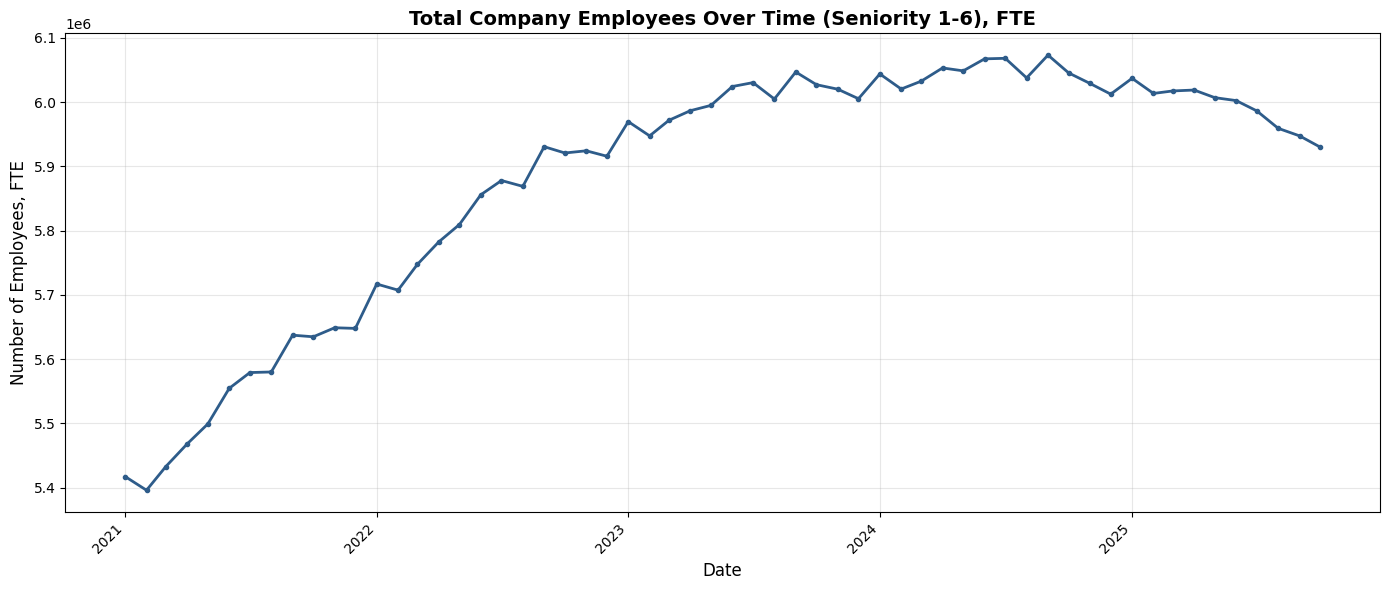


Summary Statistics, in FTE:
Peak employment: 6,073,061.095861525 employees in September 2024
Starting employment (Jan 2021): 5,417,362.711667936 employees
Current employment (Oct 2025): 5,929,852.206647669 employees


,month,total_employees
0,2021-01-01,5417362.711668
1,2021-02-01,5396083.160615
2,2021-03-01,5432896.684025
3,2021-04-01,5468195.661969
4,2021-05-01,5499265.637845
5,2021-06-01,5554608.969884
6,2021-07-01,5579150.5421
7,2021-08-01,5580071.889657
8,2021-09-01,5637314.653989
9,2021-10-01,5634805.045723


In [7]:
# Total headcount across all firms, seniority levels, and quintiles
monthly_total = (
    panel_all
    .groupby('month', as_index=False)['employment']
    .sum()
    .rename(columns={'employment': 'total_employees'})
)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(monthly_total['month'], monthly_total['total_employees'],
        linewidth=2, color='#2E5C8A', marker='o', markersize=3)

ax.set_title('Total Company Employees Over Time (Seniority 1-6), FTE', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Employees, FTE', fontsize=12)
ax.grid(True, alpha=0.3)

# Format x-axis
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

print(f"\nSummary Statistics, in FTE:")
print(f"Peak employment: {monthly_total['total_employees'].max():,} employees in {monthly_total.loc[monthly_total['total_employees'].idxmax(), 'month'].strftime('%B %Y')}")

# Jan 2021
jan_2021 = monthly_total.loc[monthly_total['month'] == pd.Timestamp('2021-01-01'), 'total_employees']
if not jan_2021.empty:
    print(f"Starting employment (Jan 2021): {jan_2021.iloc[0]:,} employees")

# Oct 2025
oct_2025 = monthly_total.loc[monthly_total['month'] == pd.Timestamp('2025-10-01'), 'total_employees']
if not oct_2025.empty:
    print(f"Current employment (Oct 2025): {oct_2025.iloc[0]:,} employees")

monthly_total

## 7. Normalize Employment by Seniority and Quintile

**Data Source**: `panel_all` (monthly employment panel)

**Objective**: Calculate normalized headcount relative to October 2022 baseline for comparison across groups

**Assumptions**:
- October 2022 (baseline_date) is the reference period = 1.0
- Groups with zero baseline employment are set to NaN

**Steps**:
- Define seniority labels for visualization
- Filter panel_all to October 2022 to get baseline employment for each seniority×quintile group
- Aggregate employment by seniority×quintile×month across all firms
- Calculate normalized headcount: `employment_t / employment_Oct2022`
- Store results in `agg_df` for plotting

In [8]:
# Define seniority labels (consistent across notebook)
seniority_labels = {
    1: 'Early Career 1',
    2: 'Early Career 2',
    3: 'Developing',
    4: 'Mid-Career 1',
    5: 'Mid-Career 2',
    6: 'Senior'
}

# Baseline month for normalization
baseline_date = pd.Timestamp('2022-10-01')

# Create normalized series directly from panel_all
normalized_df = panel_all.copy()

# Get baseline employment for each seniority × quintile group
baseline_mask = normalized_df['month'] == baseline_date

baseline_by_group = (
    normalized_df[baseline_mask]
    .groupby(['seniority', 'quintile'])['employment']
    .sum()  # Sum across all firms
    .rename('baseline_emp')
)

# Aggregate employment by seniority × quintile × month (sum across firms)
agg_df = (
    normalized_df
    .groupby(['seniority', 'quintile', 'month'], as_index=False)['employment']
    .sum()
)

# Merge baseline values
agg_df = agg_df.merge(
    baseline_by_group,
    on=['seniority', 'quintile'],
    how='left'
)

# Calculate normalized headcount
agg_df['normalized_headcount'] = np.where(
    agg_df['baseline_emp'] > 0,
    agg_df['employment'] / agg_df['baseline_emp'],
    np.nan
)

print(f"Normalized data prepared for plotting")
print(f"Total data points: {len(agg_df)}")
agg_df.head()

Normalized data prepared for plotting
Total data points: 1740


,seniority,quintile,month,employment,baseline_emp,normalized_headcount
0,1,1,2021-01-01,182971.383042,190026.723385,0.962872
1,1,1,2021-02-01,181483.152002,190026.723385,0.955040
2,1,1,2021-03-01,182297.048228,190026.723385,0.959323
3,1,1,2021-04-01,183173.424805,190026.723385,0.963935
4,1,1,2021-05-01,185980.606691,190026.723385,0.978708


## 8. Plot Normalized Employment by Seniority Level

**Data Source**: `agg_df` (normalized employment by seniority×quintile×month)

**Objective**: Create 6-panel visualization showing employment trends by AI exposure for each seniority level

**Assumptions**:
- All groups normalized to 1.0 at October 2022 baseline
- Color gradient represents AI exposure (light blue = low, dark blue = high)
- Yellow line represents overall aggregate across all quintiles

**Steps**:
- Create 2×3 subplot grid (one panel per seniority level)
- For each seniority level, plot 5 quintile lines (Q1-Q5) with blue color gradient
- Add overall line (yellow) showing aggregate across all quintiles for that seniority
- Add vertical reference line at October 2022 (ChatGPT release)
- Calculate dynamic y-axis limits based on all plotted values
- Calculate and print employment changes from baseline to last period for each seniority
- Save figure to PDF

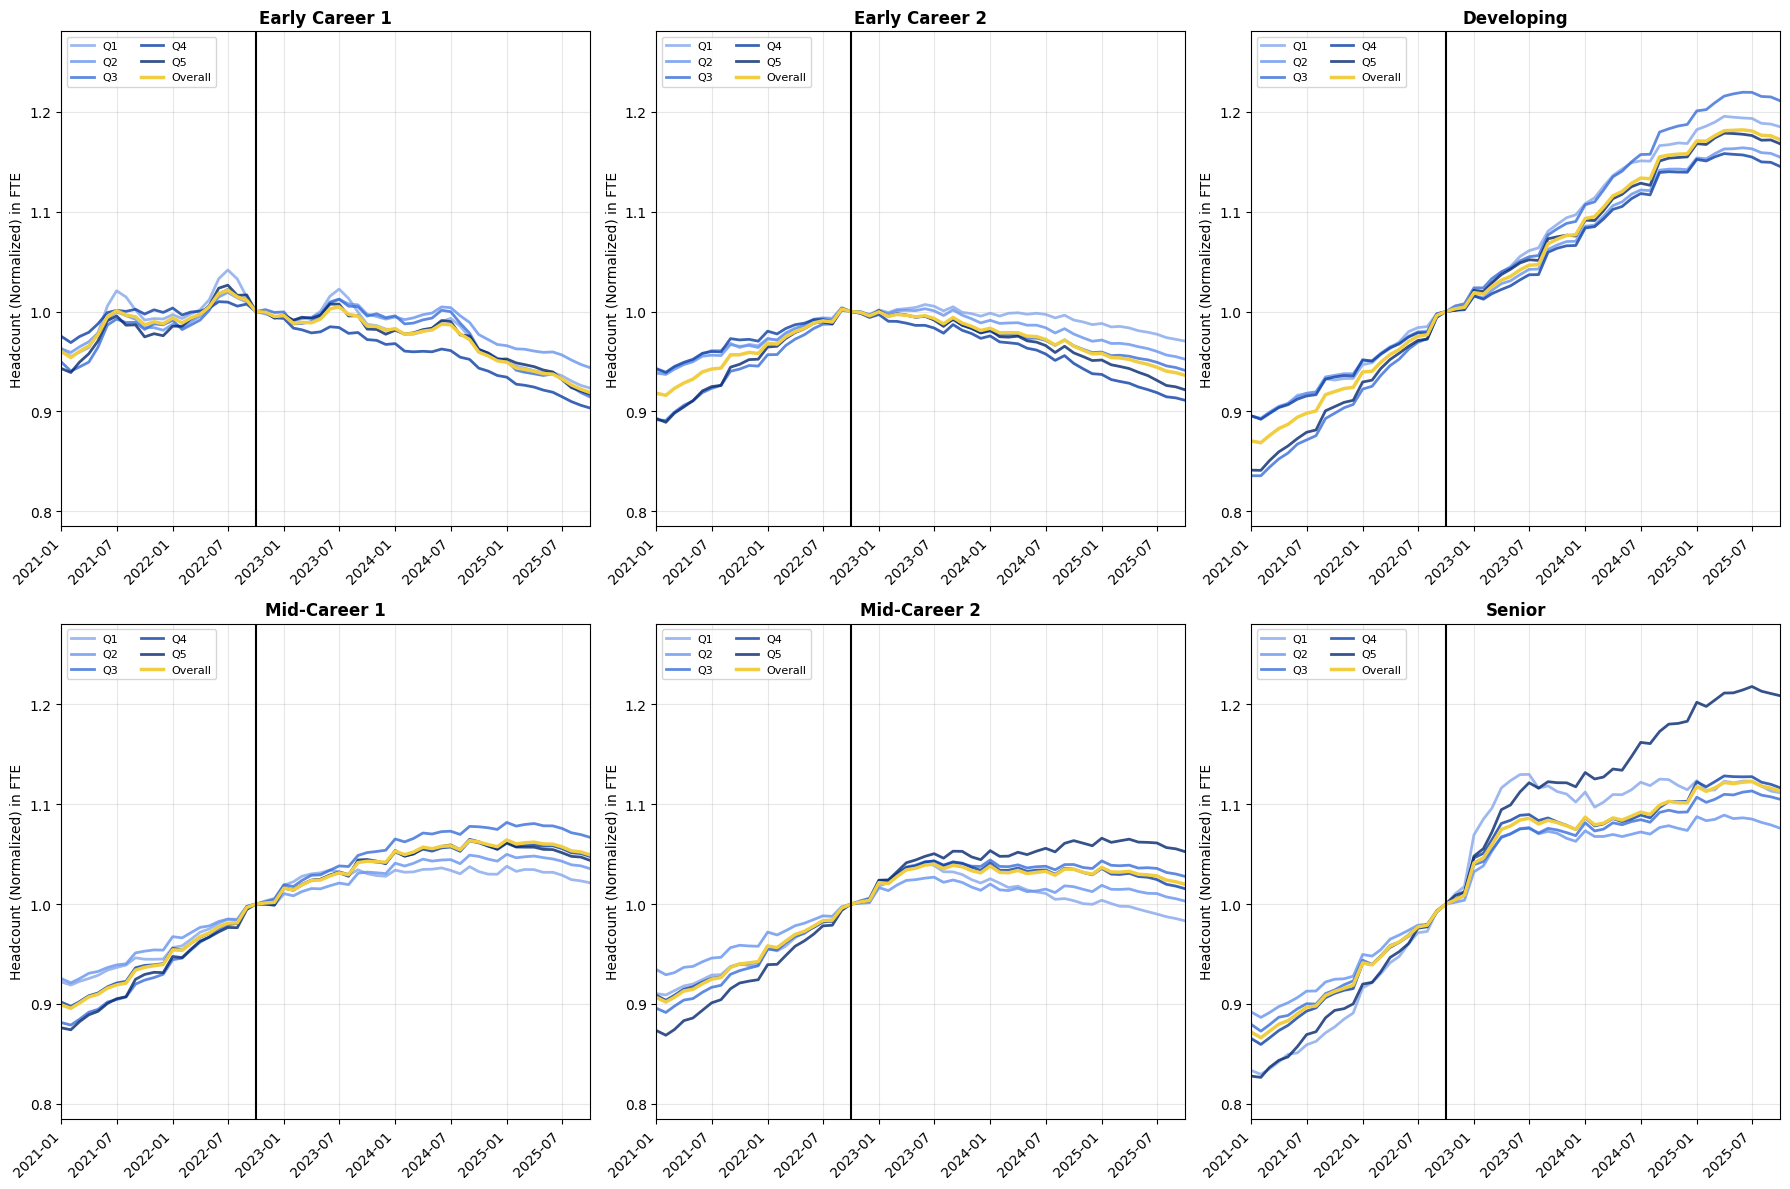

6-subplot figure completed - showing normalized employment by seniority and AI exposure

OVERALL EMPLOYMENT CHANGE - LAST MONTH (Oct 2025) vs BASELINE (Oct 2022)

Early Career 1:
  Baseline (Oct 2022): 1,403,704.29 FTE
  Last Month (Oct 2025): 1,290,019.05 FTE
  Normalized Value: 0.9190
  Change: -8.10%

Early Career 2:
  Baseline (Oct 2022): 1,780,358.00 FTE
  Last Month (Oct 2025): 1,666,798.71 FTE
  Normalized Value: 0.9362
  Change: -6.38%

Developing:
  Baseline (Oct 2022): 906,978.55 FTE
  Last Month (Oct 2025): 1,063,135.83 FTE
  Normalized Value: 1.1722
  Change: +17.22%

Mid-Career 1:
  Baseline (Oct 2022): 932,641.60 FTE
  Last Month (Oct 2025): 978,601.88 FTE
  Normalized Value: 1.0493
  Change: +4.93%

Mid-Career 2:
  Baseline (Oct 2022): 721,036.81 FTE
  Last Month (Oct 2025): 735,347.29 FTE
  Normalized Value: 1.0198
  Change: +1.98%

Senior:
  Baseline (Oct 2022): 176,034.31 FTE
  Last Month (Oct 2025): 195,949.44 FTE
  Normalized Value: 1.1131
  Change: +11.31%


In [ ]:
# Create 6 subplots (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Colors for quintiles - gradient from light to dark
colors = {
    1: "#85A7EC",  # Light blue (less exposed)
    2: "#6593EF",
    3: "#376DD9",
    4: "#0C3FA5",
    5: "#04276E"   # Dark blue (more exposed)
}

# Track all values for consistent y-axis
all_values = []

for idx, seniority in enumerate(range(1, 7)):
    ax = axes[idx]
    
    # Get label for this seniority level
    title = seniority_labels[seniority]
    
    # Filter data for this seniority
    sdata = agg_df[agg_df['seniority'] == seniority]
    
    # Plot all 5 quintiles
    for quintile in [1, 2, 3, 4, 5]:
        qdata = (
            sdata[sdata['quintile'] == quintile]
            .sort_values('month')
        )
        
        if not qdata.empty and qdata['normalized_headcount'].notna().any():
            ax.plot(
                qdata['month'],
                qdata['normalized_headcount'],
                color=colors[quintile],
                linewidth=2,
                label=f'Q{quintile}',
                alpha=0.8
            )
            all_values.extend(qdata['normalized_headcount'].dropna().tolist())
    
    # Calculate and plot overall for this seniority (sum across all quintiles)
    overall = (
        panel_all[panel_all['seniority'] == seniority]
        .groupby('month', as_index=False)['employment']
        .sum()
    )
    
    base_overall = overall.loc[overall['month'] == baseline_date, 'employment']
    if not base_overall.empty and base_overall.iloc[0] > 0:
        overall['normalized'] = overall['employment'] / base_overall.iloc[0]
        ax.plot(
            overall['month'],
            overall['normalized'],
            color="#F1CE41",
            linewidth=2.5,
            label='Overall'
        )
        all_values.extend(overall['normalized'].tolist())
    
    # Add vertical line at October 2022
    ax.axvline(x=baseline_date, color='black', linestyle='-', linewidth=1.5)
    
    # Formatting
    ax.set_title(title, fontsize=12, fontweight='bold')
    #ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Headcount (Normalized) in FTE', fontsize=10)
    ax.legend(loc='upper left', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Set x-axis limits to Jan 2021 - Oct 2025
    ax.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2025-10-01'))
    
    # Rotate x-axis labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Calculate dynamic y-axis limits based on all plotted values
if all_values:
    y_min = min(all_values) * 0.95  # 5% margin below minimum
    y_max = max(all_values) * 1.05  # 5% margin above maximum
    
    # Apply same y-axis limits to all subplots
    for idx in range(6):
        axes[idx].set_ylim(y_min, y_max)

plt.tight_layout()
plt.savefig('../Results/EU_normalized_employment_6_seniority.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

print("6-subplot figure completed - showing normalized employment by seniority and AI exposure")

# Print the last month values (change relative to Oct 2022 baseline) for each seniority level
print("\n" + "="*80)
print("OVERALL EMPLOYMENT CHANGE - LAST MONTH (Oct 2025) vs BASELINE (Oct 2022)")
print("="*80)

for seniority in range(1, 7):
    # Calculate overall employment for this seniority
    overall = (
        panel_all[panel_all['seniority'] == seniority]
        .groupby('month', as_index=False)['employment']
        .sum()
    )
    
    # Get baseline value (Oct 2022)
    base_overall = overall.loc[overall['month'] == baseline_date, 'employment']
    
    if not base_overall.empty and base_overall.iloc[0] > 0:
        # Get last month value
        last_month_data = overall.loc[overall['month'] == overall['month'].max()]
        
        if not last_month_data.empty:
            last_month_value = last_month_data['employment'].iloc[0]
            baseline_value = base_overall.iloc[0]
            normalized_value = last_month_value / baseline_value
            change_percent = (normalized_value - 1) * 100
            
            seniority_label = seniority_labels.get(seniority, f"Seniority {seniority}")
            
            print(f"\n{seniority_label}:")
            print(f"  Baseline (Oct 2022): {baseline_value:,.2f} FTE")
            print(f"  Last Month (Oct 2025): {last_month_value:,.2f} FTE")
            print(f"  Normalized Value: {normalized_value:.4f}")
            print(f"  Change: {change_percent:+.2f}%")


## 9. Build Firm-Level Panel for Regression

**Data Source**: `panel_all` (monthly employment panel)

**Objective**: Aggregate employment to firm×quintile×month level for Brynjolfsson regression analysis

**Assumptions**:
- Regression uses Poisson model with firm-quintile and firm-month fixed effects
- Aggregating across all seniority levels creates baseline panel

**Steps**:
- Group panel_all by firm (rcid), quintile, month, and month_relative
- Sum employment across all seniority levels
- Display panel structure: number of firms, months, quintiles, and observations
- Calculate percentage of zero-employment cells

In [10]:
# Build firm × quintile × month panel for all seniorities combined (from panel_all)
panel_df = (
    panel_all
    .groupby(['rcid', 'quintile', 'month', 'month_relative'], as_index=False)['employment']
    .sum()
)

print(f"Firm-quintile-month panel created from panel_all")
print(f"\nPanel structure:")
print(f"  Firms: {panel_df['rcid'].nunique()}")
print(f"  Months: {panel_df['month'].nunique()}")
print(f"  Quintiles: {panel_df['quintile'].nunique()}")
print(f"  Total observations: {len(panel_df):,}")
print(f"  Zero employment cells: {(panel_df['employment'] == 0).sum():,} ({(panel_df['employment'] == 0).sum() / len(panel_df) * 100:.1f}%)")

panel_df.head(10)

Firm-quintile-month panel created from panel_all

Panel structure:
  Firms: 2150
  Months: 58
  Quintiles: 5
  Total observations: 621,934
  Zero employment cells: 3,341 (0.5%)


,rcid,quintile,month,month_relative,employment
0,45.0,1,2021-01-01,-21,58.201669
1,45.0,1,2021-02-01,-20,58.201669
2,45.0,1,2021-03-01,-19,58.201669
3,45.0,1,2021-04-01,-18,58.201669
4,45.0,1,2021-05-01,-17,58.201669
5,45.0,1,2021-06-01,-16,58.201669
6,45.0,1,2021-07-01,-15,58.201669
7,45.0,1,2021-08-01,-14,58.201669
8,45.0,1,2021-09-01,-13,59.445013
9,45.0,1,2021-10-01,-12,59.445013


## 10. Apply Sample Restrictions by Seniority Level

**Data Source**: `panel_all` (monthly employment panel)

**Objective**: Create separate regression-ready panels for each seniority level with Brynjolfsson sample restrictions

**Sample Restrictions**:
1. Minimum monthly employment: Firm must have ≥10 employees every month
2. Minimum quintile coverage: Firm must have ≥100 total employees in each of the 5 quintiles
3. Complete quintile set: All 5 quintiles must be present

**Assumptions**:
- High-dimensional fixed effects require sufficient within-firm variation
- Firms with sporadic employment or missing quintiles cannot identify coefficients

**Steps**:
- Loop through seniority levels 1-6
- Filter panel_all to current seniority and aggregate by firm×quintile×month
- Calculate firm-level employment totals by quintile
- Calculate minimum monthly employment per firm
- Apply both restrictions and identify qualifying firms
- Store restricted panels in `seniority_panels` dictionary

In [11]:
# Create separate panels for each seniority level (from panel_all)
# This will allow us to run regressions by age group as in Brynjolfsson

seniority_panels = {}

for seniority in range(1, 7):
    print(f"\n{'='*60}")
    print(f"Processing Seniority Level {seniority}")
    print(f"{'='*60}")
    
    # Filter panel_all to this seniority and aggregate by firm × quintile × month
    sp = (
        panel_all[panel_all['seniority'] == seniority]
        .groupby(['rcid', 'quintile', 'month', 'month_relative'], as_index=False)['employment']
        .sum()
    )
    
    if sp.empty:
        print(f"  ⚠️  WARNING: No data for seniority {seniority}")
        seniority_panels[seniority] = None
        continue
    
    print(f"\nBefore restrictions:")
    print(f"  Firms: {sp['rcid'].nunique()}")
    print(f"  Total observations: {len(sp):,}")
    print(f"  Mean employment per cell: {sp['employment'].mean():.2f}")
    
    # Apply Brynjolfsson restrictions:
    # 1. Total employment per firm × quintile (across all months)
    firm_quintile_totals = (
        sp
        .groupby(['rcid', 'quintile'], as_index=False)['employment']
        .sum()
        .rename(columns={'employment': 'total_employment'})
    )
    
    # 2. Min employment per month by firm (sum over quintiles)
    firm_month_tot = (
        sp
        .groupby(['rcid', 'month'], as_index=False)['employment']
        .sum()
    )
    firm_min_emp = (
        firm_month_tot
        .groupby('rcid', as_index=False)['employment']
        .min()
        .rename(columns={'employment': 'min_monthly_employment'})
    )
    
    # Firms with ≥10 workers in every period
    valid1 = firm_min_emp.loc[firm_min_emp['min_monthly_employment'] >= 10, 'rcid']
    
    # Firms with ≥100 total employment for EACH quintile (strict: requires all 5 quintiles)
    valid2 = (
        firm_quintile_totals
        .groupby('rcid')
        .filter(lambda g: (g['quintile'].nunique() == 5) and (g['total_employment'] >= 100).all())['rcid']
        .unique()
    )
    
    valid_firms = set(valid1).intersection(set(valid2))
    
    print(f"\nSample restrictions:")
    print(f"  Firms with ≥10 workers every period: {len(valid1)}")
    print(f"  Firms with ≥100 total per quintile: {len(valid2)}")
    print(f"  Firms meeting both criteria: {len(valid_firms)}")
    
    if not valid_firms:
        print(f"  ⚠️  WARNING: No firms meet the sample restrictions for seniority {seniority}")
        seniority_panels[seniority] = None
    else:
        restricted = sp[sp['rcid'].isin(valid_firms)].copy()
        
        print(f"\nAfter restrictions:")
        print(f"  Observations: {len(restricted):,}")
        print(f"  Mean employment per cell: {restricted['employment'].mean():.2f}")
        print(f"  Zero employment cells: {(restricted['employment'] == 0).sum():,} ({(restricted['employment'] == 0).sum() / len(restricted) * 100:.1f}%)")
        
        seniority_panels[seniority] = restricted

print(f"\n{'='*60}")
print(f"Summary: Successfully created panels for {sum(1 for v in seniority_panels.values() if v is not None)} seniority levels")
print(f"{'='*60}")


Processing Seniority Level 1

Before restrictions:
  Firms: 2150
  Total observations: 609,812
  Mean employment per cell: 130.64

Sample restrictions:
  Firms with ≥10 workers every period: 1957
  Firms with ≥100 total per quintile: 1591
  Firms meeting both criteria: 1587

After restrictions:
  Observations: 460,230
  Mean employment per cell: 170.02
  Zero employment cells: 432 (0.1%)

Processing Seniority Level 2

Before restrictions:
  Firms: 2150
  Total observations: 614,278
  Mean employment per cell: 162.77

Sample restrictions:
  Firms with ≥10 workers every period: 2088
  Firms with ≥100 total per quintile: 1666
  Firms meeting both criteria: 1663

After restrictions:
  Observations: 482,270
  Mean employment per cell: 203.47
  Zero employment cells: 358 (0.1%)

Processing Seniority Level 3

Before restrictions:
  Firms: 2148
  Total observations: 592,760
  Mean employment per cell: 92.28

Sample restrictions:
  Firms with ≥10 workers every period: 1949
  Firms with ≥100 to

## 11. Estimate Poisson Regressions by Seniority Level

**Data Source**: `seniority_panels` dictionary (restricted panels from previous step)

**Objective**: Run 6 separate Poisson TWFE regressions to estimate differential employment effects by AI exposure

**Assumptions**:
- Employment follows Poisson distribution (count data)
- Firm-quintile and firm-month fixed effects control for confounding factors
- Reference categories: Quintile 1 (lowest AI exposure), October 2022 (baseline month)

**Steps**:
- Loop through each seniority level
- Clean employment variable (remove tiny negative values from floating point errors)
- Create firm-quintile and firm-month fixed effect identifiers
- Generate manual quintile×month interaction dummies (e.g., Q2_Mp5 = Quintile 2, Month +5)
- Estimate Poisson model: `employment ~ Q×t_interactions | firm_quintile + firm_month`
- Cluster standard errors by firm (rcid)
- Store results in `regression_results` dictionary

In [12]:
# Run Brynjolfsson Poisson regression for each seniority level
regression_results = {}

for seniority in range(1, 7):
    if seniority_panels[seniority] is None:
        print(f"\nSkipping seniority {seniority} - insufficient sample")
        continue
    
    print(f"\n{'='*60}")
    print(f"Estimating Brynjolfsson specification for Seniority {seniority}")
    print(f"{'='*60}")
    
    df = seniority_panels[seniority].copy()

    # Clean employment variable to handle floating point precision issues
    eps = 1e-10
    if (df["employment"] < -eps).any():
        bad = df.loc[df["employment"] < -eps, ["rcid","quintile","month_relative","employment"]].head(20)
        raise ValueError(f"Found employment < -{eps}. Example rows:\n{bad}")

    df.loc[df["employment"].between(-eps, 0), "employment"] = 0.0
    df["employment"] = df["employment"].clip(lower=0.0)

    # Create fixed-effect identifiers (use category dtype for memory efficiency)
    df['firm_quintile'] = (df['rcid'].astype(str) + '_Q' + df['quintile'].astype(str)).astype('category')
    df['firm_month'] = (df['rcid'].astype(str) + '_M' + df['month_relative'].astype(str)).astype('category')

    print(f"Sample size: {len(df)} observations")
    print(f"Employment range: {df['employment'].min()} to {df['employment'].max()}")
    print(f"Mean employment: {df['employment'].mean():.2f}")

    try:
        # Create quintile×month interaction dummies manually (excluding reference categories)
        # This creates the full γ(q,t) grid of event-time coefficients
        
        # Get unique quintiles and months
        quintiles = sorted(df['quintile'].unique())
        months_rel = sorted(df['month_relative'].unique())
        
        # Create all interaction dummies at once to avoid DataFrame fragmentation
        # Exclude quintile=1 (reference) and month=0 (October 2022 baseline)
        interaction_dummies = {}
        interaction_terms = []
        
        for q in quintiles:
            if q == 1:  # Skip reference quintile
                continue
            for m in months_rel:
                if m == 0:  # Skip reference month (Oct 2022)
                    continue
                
                # Create dummy variable with safe naming (handle negative months)
                # Use 'n' prefix for negative, 'p' for positive
                if m < 0:
                    var_name = f'Q{q}_Mn{abs(m)}'
                else:
                    var_name = f'Q{q}_Mp{m}'               
                interaction_dummies[var_name] = ((df['quintile'] == q) & (df['month_relative'] == m)).astype(int)
                interaction_terms.append(var_name)
        
        # Add all dummy columns at once using pd.concat (much faster than iterative assignment)
        dummy_df = pd.DataFrame(interaction_dummies, index=df.index)
        df = pd.concat([df, dummy_df], axis=1)
        
        # Build formula with manual interaction dummies
        formula = f"employment ~ {' + '.join(interaction_terms)} | firm_quintile + firm_month"
        
        print(f"\nEstimating Poisson TWFE with manual event-time dummies...")
        print(f"Fixed effects: firm-quintile ({df['firm_quintile'].nunique()} groups) + firm-month ({df['firm_month'].nunique()} groups)")
        print(f"Interaction variables: {len(interaction_terms)} quintile×month dummies")
        
        # Estimate model with clustered standard errors by firm
        model = pf.fepois(formula, data=df, vcov={'CRV1': 'rcid'})
        
        print("\nRegression completed successfully!")
        print(f"Coefficients estimated: {len(model.coef().index)}")
        
        regression_results[seniority] = {"model": model, "data": df}
        
        # Print summary
        print(model.summary())

    except Exception as e:
        print(f"ERROR estimating model for seniority {seniority}: {str(e)}")
        import traceback
        traceback.print_exc()
        regression_results[seniority] = None

print("\nCompleted regressions for", sum(1 for v in regression_results.values() if v is not None), "seniority levels")



Estimating Brynjolfsson specification for Seniority 1
Sample size: 460230 observations
Employment range: 0.0 to 22602.197900235
Mean employment: 170.02

Estimating Poisson TWFE with manual event-time dummies...
Fixed effects: firm-quintile (7935 groups) + firm-month (92046 groups)
Interaction variables: 228 quintile×month dummies

Regression completed successfully!
Coefficients estimated: 228
###

Estimation:  Poisson
Dep. var.: employment, Fixed effects: firm_quintile+firm_month
Inference:  CRV1
Observations:  460230

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Q2_Mn21       |      0.006 |        0.008 |     0.677 |      0.498 | -0.011 |   0.022 |
| Q2_Mn20       |      0.009 |        0.008 |     1.081 |      0.280 | -0.007 |   0.026 |
| Q2_Mn19       |      0.010 |        0.008 |     1.290 |      0.197 | -0.005 |   0.025 |
| Q2_Mn18       |      0

## 12. Extract Summary Statistics from Regressions

**Data Source**: `regression_results` dictionary (fitted Poisson models)

**Objective**: Extract coefficients and confidence intervals for downstream plotting and analysis

**Assumptions**:
- Coefficients represent log-linear effects relative to Q1 at October 2022
- 95% confidence intervals calculated as coef ± 1.96*SE

**Steps**:
- Loop through seniority levels 1-6
- For each quintile 2-5, extract coefficients for all time periods
- Parse coefficient names to determine month relative to baseline
- Calculate confidence intervals
- Store post-period statistics (average and last period effects)
- Convert log coefficients to percentage changes using exp(coef)-1

In [13]:
# Extract summary statistics needed for the overlay plot
# This prepares data without creating the 24-panel plot

# Use consistent seniority labels
seniority_labels_plot = {
    1: '(a) Early Career 1',
    2: '(b) Early Career 2',
    3: '(c) Developing',
    4: '(d) Mid-Career 1',
    5: '(e) Mid-Career 2',
    6: '(f) Senior'
}

# Baseline month
baseline_date = pd.Timestamp('2022-10-01')

# Store summary statistics for post-estimation reporting
summary_stats = {}

for seniority in range(1, 7):
    summary_stats[seniority] = {}
    
    if regression_results.get(seniority) is None:
        continue
    
    model = regression_results[seniority]['model']
    coefs = model.coef()
    se = model.se()
    
    # Process quintiles 2-5 only (quintile 1 is reference)
    for quintile in [2, 3, 4, 5]:
        months_list = []
        coef_list = []
        ci_lower_list = []
        ci_upper_list = []
        
        # Add baseline point
        months_list.append(0)
        coef_list.append(0.0)
        ci_lower_list.append(0.0)
        ci_upper_list.append(0.0)
        
        # Extract coefficients for this quintile
        for coef_name in coefs.index:
            if coef_name.startswith(f'Q{quintile}_Mp') or coef_name.startswith(f'Q{quintile}_Mn'):
                try:
                    if '_Mp' in coef_name:
                        month_part = coef_name.split('_Mp')[1]
                        month_t = int(month_part)
                    else:
                        month_part = coef_name.split('_Mn')[1]
                        month_t = -int(month_part)
                    
                    coef_val = coefs.loc[coef_name]
                    se_val = se.loc[coef_name]
                    
                    months_list.append(month_t)
                    coef_list.append(coef_val)
                    ci_lower_list.append(coef_val - 1.96 * se_val)
                    ci_upper_list.append(coef_val + 1.96 * se_val)
                except (IndexError, ValueError):
                    continue
        
        # Sort by month
        sorted_indices = sorted(range(len(months_list)), key=lambda i: months_list[i])
        coefs_sorted = [coef_list[i] for i in sorted_indices]
        ci_lower_sorted = [ci_lower_list[i] for i in sorted_indices]
        ci_upper_sorted = [ci_upper_list[i] for i in sorted_indices]
        months_sorted = [months_list[i] for i in sorted_indices]
        
        # Calculate post-period statistics
        post_period_mask = [m >= 0 for m in months_sorted]
        post_coefs = [coefs_sorted[i] for i in range(len(coefs_sorted)) if post_period_mask[i]]
        
        avg_post_coef = np.mean(post_coefs) if post_coefs else np.nan
        last_period_coef = coefs_sorted[-1] if coefs_sorted else np.nan
        last_period_ci_lower = ci_lower_sorted[-1] if ci_lower_sorted else np.nan
        last_period_ci_upper = ci_upper_sorted[-1] if ci_upper_sorted else np.nan
        last_period_sig = (last_period_ci_lower > 0 or last_period_ci_upper < 0) if not np.isnan(last_period_ci_lower) else False
        
        # Store summary statistics
        summary_stats[seniority][quintile] = {
            'avg_post_coef': avg_post_coef,
            'avg_post_pct_change': (np.exp(avg_post_coef) - 1) * 100 if not np.isnan(avg_post_coef) else np.nan,
            'last_period_coef': last_period_coef,
            'last_period_pct_change': (np.exp(last_period_coef) - 1) * 100 if not np.isnan(last_period_coef) else np.nan,
            'last_period_sig': last_period_sig
        }

print("Summary statistics computed - ready for overlay plot")


Summary statistics computed - ready for overlay plot


## 13. Create Overlay Plot: Raw vs. Regression-Adjusted Effects

**Data Sources**: 
- `agg_df` (normalized employment trends)
- `regression_results` (fitted Poisson model coefficients)

**Objective**: Create 6×4 panel plot comparing raw trends with regression-adjusted effects for each seniority×quintile combination

**Assumptions**:
- Raw trends show overall employment changes including all confounding factors
- Regression effects isolate AI-specific impacts after controlling for firm shocks
- Both series normalized to October 2022 baseline

**Steps**:
- Create 6 rows (seniority levels) × 4 columns (quintiles 2-5) subplot grid
- For each panel:
  - Plot raw normalized employment (yellow solid line) from agg_df
  - Plot regression coefficients with 95% CI (blue dashed line) from models
  - Add reference lines (horizontal at 0, vertical at Oct 2022)
- Calculate and display summary statistics comparing raw vs. regression effects
- Test statistical significance using t-tests
- Save figure to PDF

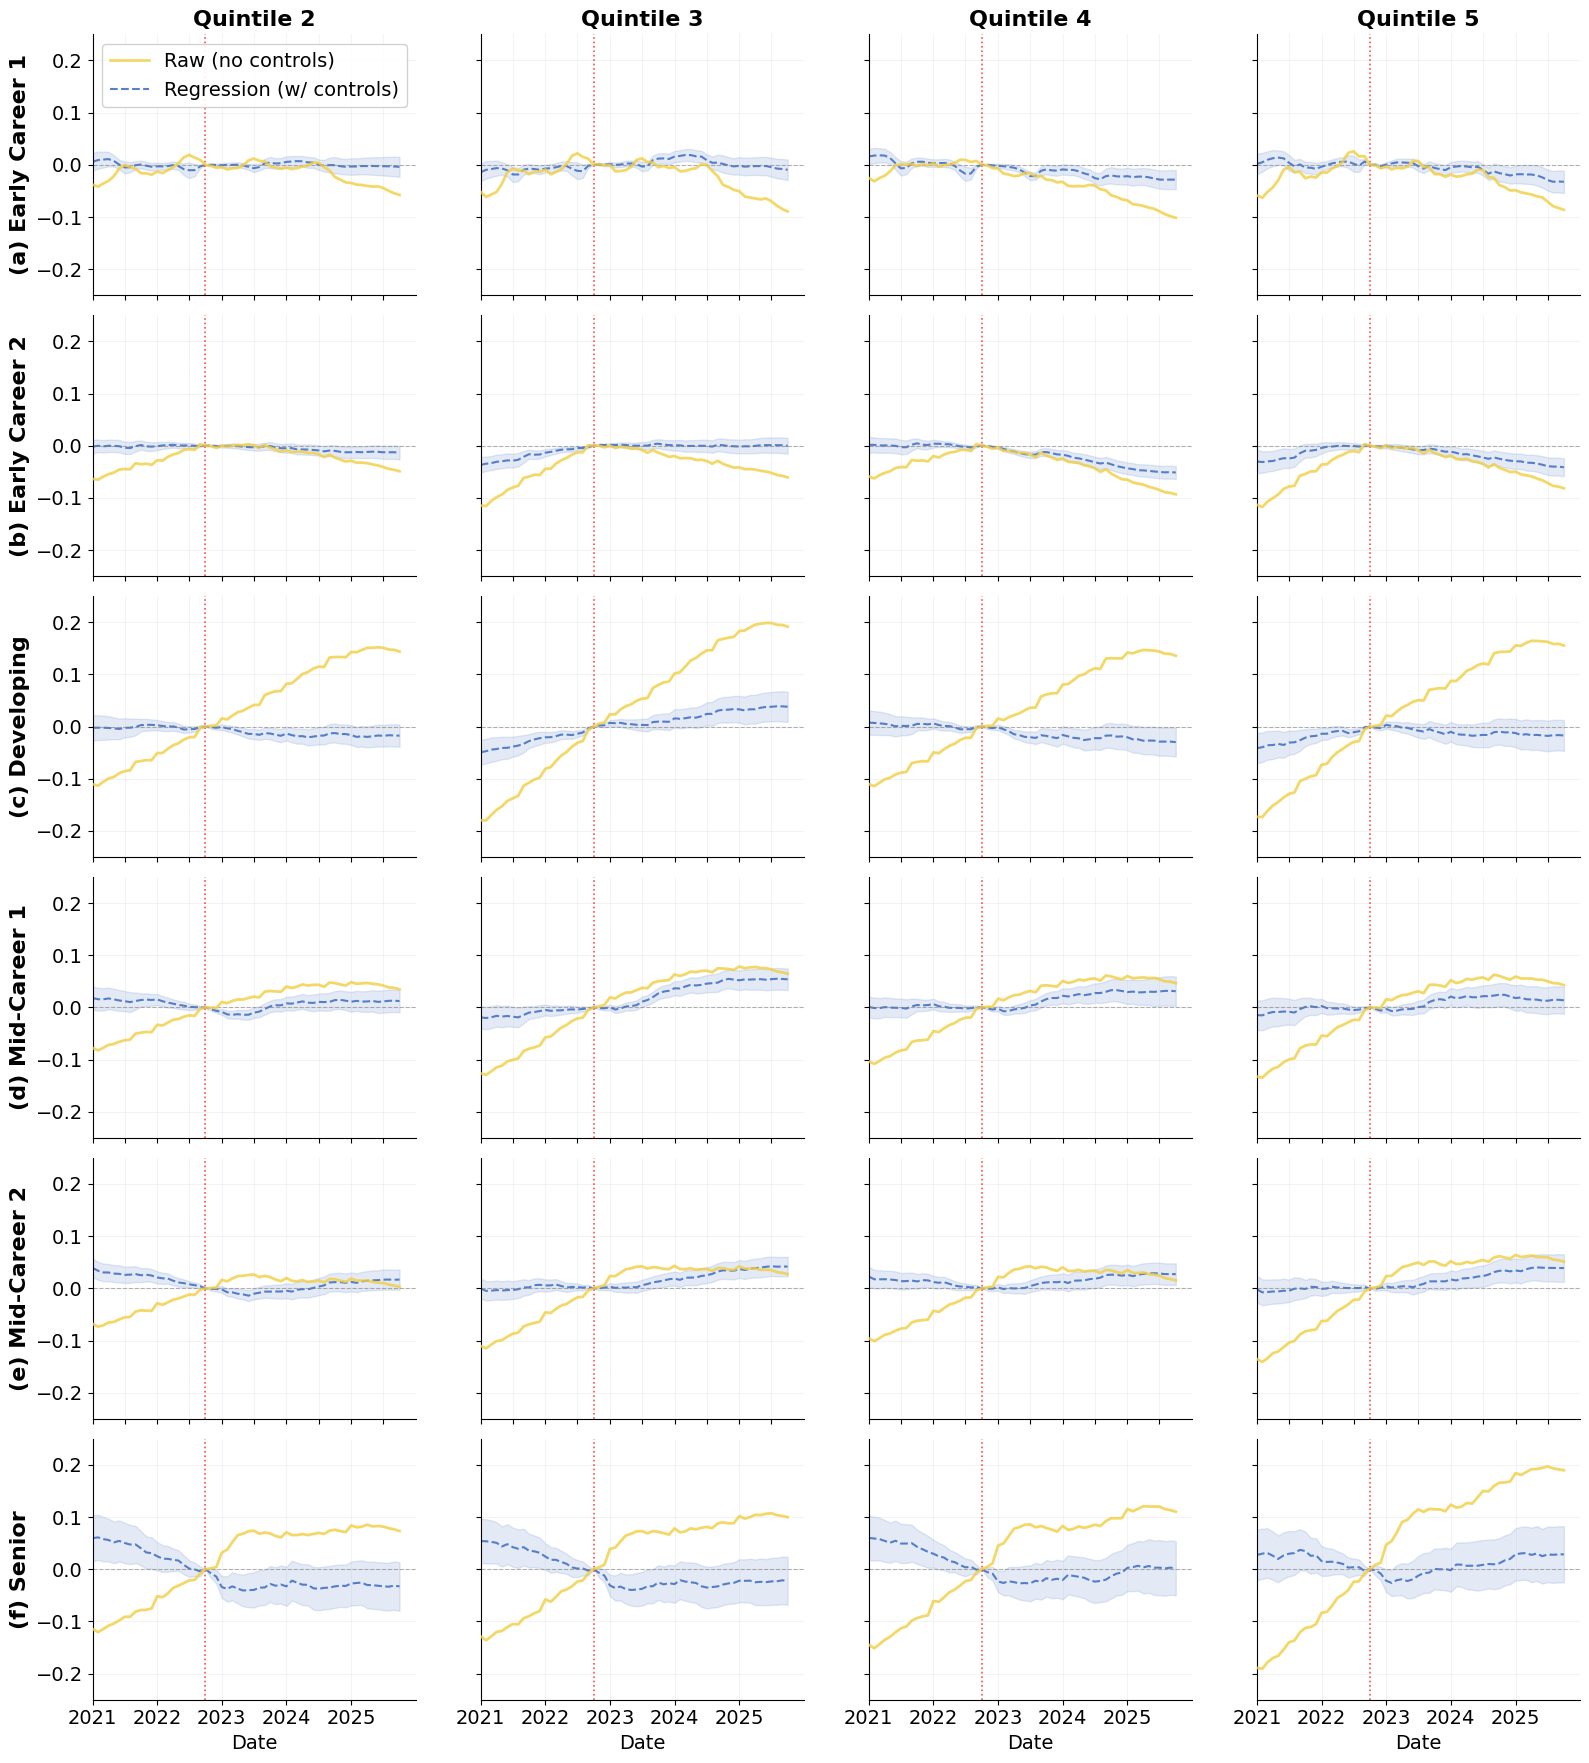


COMPARISON SUMMARY: RAW TRENDS vs. REGRESSION-ADJUSTED EFFECTS

Post-ChatGPT Period: October 2022 onwards (t ≥ 0)
Reference Category: Quintile 1 (lowest AI exposure)

SENIORITY LEVEL 1: (a) Early Career 1

  Quintile 2 (relative to Q1):
  ----------------------------------------------------------------------

    RAW TRENDS (No Controls):
      Average post-period effect:    -0.0155 log points (-1.54%)
      Last period effect (Oct 2025): -0.0578 log points (-5.61%)

    REGRESSION-ADJUSTED EFFECTS (With Firm FE Controls):
      Average post-period effect:    -0.0002 log points (-0.02%) [SE: 0.0055]
      Last period effect (Oct 2025): -0.0038 log points (-0.38%) [SE: 0.0097]
      Statistical significance:       NO (95% CI includes zero in last period)

    DIFFERENCE (Raw - Regression):
      Average post-period:            -0.0153 log points
      Last period:                    -0.0540 log points
      Interpretation: Raw trends and regression effects are similar.
                

In [ ]:
# Overlay plot: Raw employment trends vs. regression-adjusted effects
# Display only quintiles 2-5 (quintile 1 is reference category)

# Import scipy.stats for significance testing
from scipy import stats as scipy_stats

# Use consistent seniority labels
seniority_labels_overlay = {
    1: '(a) Early Career 1',
    2: '(b) Early Career 2',
    3: '(c) Developing',
    4: '(d) Mid-Career 1',
    5: '(e) Mid-Career 2',
    6: '(f) Senior'
}

# Create figure with 6 rows × 4 columns
fig, axes = plt.subplots(6, 4, figsize=(16, 18))

# Baseline month
baseline_date = pd.Timestamp('2022-10-01')

# Store summary statistics for both raw and regression-adjusted
comparison_stats = {}

for row_idx, seniority in enumerate(range(1, 7)):
    comparison_stats[seniority] = {}
    
    if regression_results.get(seniority) is None:
        # If no results, mark all 4 quintile panels as insufficient sample
        for col_idx in range(4):
            ax = axes[row_idx, col_idx]
            ax.text(0.5, 0.5, 'Insufficient\nSample', 
                   ha='center', va='center', fontsize=10, color='gray')
            if col_idx == 0:
                ax.set_ylabel(seniority_labels_overlay[seniority], fontsize=10, fontweight='bold')
            if row_idx == 0:
                ax.set_title(f'Quintile {col_idx + 2}', fontsize=10, fontweight='bold')
            ax.set_xlim(datetime(2021, 1, 1), datetime(2025, 12, 31))
            ax.set_ylim(-0.25, 0.25)
        continue
    
    # Get regression results
    model = regression_results[seniority]['model']
    coefs = model.coef()
    se = model.se()
    
    # Get raw employment data for this seniority level
    raw_seniority = agg_df[agg_df['seniority'] == seniority].copy()
    
    # Plot quintiles 2-5 only
    for col_idx, quintile in enumerate([2, 3, 4, 5]):
        ax = axes[row_idx, col_idx]
        comparison_stats[seniority][quintile] = {}
        
        # ====================================================================
        # PART 1: Plot raw normalized employment (each quintile to its own Oct 2022)
        # ====================================================================
        
        # Get current quintile data (already normalized to Oct 2022 in agg_df)
        qx_data = raw_seniority[raw_seniority['quintile'] == quintile].sort_values('month').copy()
        
        # Convert normalized_headcount to log points (baseline Oct 2022 = 1.0, so log(1.0) = 0)
        qx_data['log_normalized'] = np.log(qx_data['normalized_headcount'])
        
        # Plot raw trend (solid line)
        if not qx_data.empty and qx_data['log_normalized'].notna().any():
            ax.plot(qx_data['month'], qx_data['log_normalized'], 
                   color="#F1CE41", linewidth=2, alpha=0.8, 
                   label='Raw (no controls)', zorder=3)
            
            # Calculate raw statistics for post-period
            post_raw = qx_data[qx_data['month'] >= baseline_date]
            if not post_raw.empty:
                avg_raw_coef = post_raw['log_normalized'].mean()
                last_raw_coef = post_raw.iloc[-1]['log_normalized']
                
                comparison_stats[seniority][quintile]['raw_avg_post'] = avg_raw_coef
                comparison_stats[seniority][quintile]['raw_avg_post_pct'] = (np.exp(avg_raw_coef) - 1) * 100
                comparison_stats[seniority][quintile]['raw_last'] = last_raw_coef
                comparison_stats[seniority][quintile]['raw_last_pct'] = (np.exp(last_raw_coef) - 1) * 100
        
        # ====================================================================
        # PART 2: Plot regression coefficients (with controls)
        # ====================================================================
        
        months_list = []
        dates_list = []
        coef_list = []
        ci_lower_list = []
        ci_upper_list = []
        
        # Add baseline point
        months_list.append(0)
        dates_list.append(baseline_date)
        coef_list.append(0.0)
        ci_lower_list.append(0.0)
        ci_upper_list.append(0.0)
        
        # Extract coefficients
        for coef_name in coefs.index:
            if coef_name.startswith(f'Q{quintile}_Mp') or coef_name.startswith(f'Q{quintile}_Mn'):
                try:
                    if '_Mp' in coef_name:
                        month_part = coef_name.split('_Mp')[1]
                        month_t = int(month_part)
                    else:
                        month_part = coef_name.split('_Mn')[1]
                        month_t = -int(month_part)
                    
                    coef_val = coefs.loc[coef_name]
                    se_val = se.loc[coef_name]
                    actual_date = baseline_date + pd.DateOffset(months=month_t)
                    
                    months_list.append(month_t)
                    dates_list.append(actual_date)
                    coef_list.append(coef_val)
                    ci_lower_list.append(coef_val - 1.96 * se_val)
                    ci_upper_list.append(coef_val + 1.96 * se_val)
                except (IndexError, ValueError):
                    continue
        
        # Sort by month
        sorted_indices = sorted(range(len(months_list)), key=lambda i: months_list[i])
        dates_sorted = [dates_list[i] for i in sorted_indices]
        coefs_sorted = [coef_list[i] for i in sorted_indices]
        ci_lower_sorted = [ci_lower_list[i] for i in sorted_indices]
        ci_upper_sorted = [ci_upper_list[i] for i in sorted_indices]
        months_sorted = [months_list[i] for i in sorted_indices]
        
        # Calculate regression statistics
        post_period_mask = [m >= 0 for m in months_sorted]
        post_coefs = [coefs_sorted[i] for i in range(len(coefs_sorted)) if post_period_mask[i]]
        post_ci_lower = [ci_lower_sorted[i] for i in range(len(ci_lower_sorted)) if post_period_mask[i]]
        post_ci_upper = [ci_upper_sorted[i] for i in range(len(ci_upper_sorted)) if post_period_mask[i]]
        
        # Calculate SE from confidence intervals (CI = coef ± 1.96*SE, so SE = (CI_upper - coef)/1.96)
        post_se = [(ci_upper_sorted[i] - coefs_sorted[i]) / 1.96 for i in range(len(coefs_sorted)) if post_period_mask[i]]
        
        avg_reg_coef = np.mean(post_coefs) if post_coefs else np.nan
        avg_reg_se = np.mean(post_se) if post_se else np.nan  # Average SE
        last_reg_coef = coefs_sorted[-1] if coefs_sorted else np.nan
        last_reg_se = (ci_upper_sorted[-1] - coefs_sorted[-1]) / 1.96 if ci_upper_sorted else np.nan
        last_ci_lower = ci_lower_sorted[-1] if ci_lower_sorted else np.nan
        last_ci_upper = ci_upper_sorted[-1] if ci_upper_sorted else np.nan
        last_reg_sig = (last_ci_lower > 0 or last_ci_upper < 0) if not np.isnan(last_ci_lower) else False
        
        comparison_stats[seniority][quintile]['reg_avg_post'] = avg_reg_coef
        comparison_stats[seniority][quintile]['reg_avg_post_se'] = avg_reg_se
        comparison_stats[seniority][quintile]['reg_avg_post_pct'] = (np.exp(avg_reg_coef) - 1) * 100 if not np.isnan(avg_reg_coef) else np.nan
        comparison_stats[seniority][quintile]['reg_last'] = last_reg_coef
        comparison_stats[seniority][quintile]['reg_last_se'] = last_reg_se
        comparison_stats[seniority][quintile]['reg_last_pct'] = (np.exp(last_reg_coef) - 1) * 100 if not np.isnan(last_reg_coef) else np.nan
        comparison_stats[seniority][quintile]['reg_last_sig'] = last_reg_sig
        
        # Plot regression coefficients (dashed line)
        ax.plot(dates_sorted, coefs_sorted, 
               color='#4472C4', linewidth=1.5, linestyle='--', alpha=0.9,
               label='Regression (w/ controls)', zorder=2)
        
        # Plot confidence interval
        ax.fill_between(dates_sorted, ci_lower_sorted, ci_upper_sorted, 
                        color='#4472C4', alpha=0.15, zorder=1)
        
        # ====================================================================
        # Formatting
        # ====================================================================
        
        # Add horizontal dashed line at zero
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
        
        # Add vertical red line at October 2022
        ax.axvline(x=baseline_date, color='red', linestyle=':', linewidth=1.2, alpha=0.7)
        
        # Formatting
        ax.set_xlim(datetime(2021, 1, 1), datetime(2025, 12, 31))
        ax.set_ylim(-0.25, 0.25)
        
        # Grid
        ax.grid(True, alpha=0.2, linewidth=0.5)
        
        # Y-axis labels only on leftmost column
        if col_idx == 0:
            ax.set_ylabel(seniority_labels_overlay[seniority], fontsize=16, fontweight='bold')
            ax.tick_params(axis='y', labelsize=14)
        else:
            ax.set_yticklabels([])
        
        # X-axis labels only on bottom row
        if row_idx == 5:
            ax.set_xlabel('Date', fontsize=14)
            ax.tick_params(axis='x', labelsize=14, rotation=0)
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        else:
            ax.set_xticklabels([])
        
        # Column titles only on top row
        if row_idx == 0:
            ax.set_title(f'Quintile {quintile}', fontsize=16, fontweight='bold')
        
        # Legend only on top-left panel
        if row_idx == 0 and col_idx == 0:
            ax.legend(loc='upper left', fontsize=14, framealpha=0.9)
        
        # Clean spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Overall title
# fig.suptitle('Comparison: Raw Employment Trends vs. Regression-Adjusted Effects\n' + 
#              'Red line = raw normalized employment for each quintile (no controls). Blue dashed = regression coefficients (w/ firm FE).\n' +
#              'Each quintile normalized to its own Oct 2022 baseline. Vertical line marks ChatGPT release.\n' +
#              'Shaded regions are 95% confidence intervals for regression estimates.',
#              fontsize=11, y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.savefig('../Results/EU_overlay_comparison_raw_vs_regression.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# COMPARISON SUMMARY: RAW vs. REGRESSION-ADJUSTED EFFECTS
# ============================================================================

print("\n" + "="*80)
print("COMPARISON SUMMARY: RAW TRENDS vs. REGRESSION-ADJUSTED EFFECTS")
print("="*80)
print("\nPost-ChatGPT Period: October 2022 onwards (t ≥ 0)")
print("Reference Category: Quintile 1 (lowest AI exposure)")
print("="*80)

# Function to calculate significance stars
def get_stars(coef, se):
    if se == 0 or np.isnan(se) or np.isnan(coef):
        return ''
    t_stat = abs(coef / se)
    p_value = 2 * (1 - scipy_stats.norm.cdf(t_stat))  # Two-tailed test
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.10:
        return '*'
    else:
        return ''

for seniority in range(1, 7):
    if regression_results.get(seniority) is None:
        continue
    
    print(f"\n{'='*80}")
    print(f"SENIORITY LEVEL {seniority}: {seniority_labels_overlay[seniority]}")
    print(f"{'='*80}")
    
    for quintile in [2, 3, 4, 5]:
        stats = comparison_stats[seniority][quintile]
        
        # Get significance stars
        avg_stars = get_stars(stats['reg_avg_post'], stats['reg_avg_post_se'])
        last_stars = get_stars(stats['reg_last'], stats['reg_last_se'])
        
        print(f"\n  Quintile {quintile} (relative to Q1):")
        print(f"  {'-'*70}")
        
        # Raw trends (no controls)
        print(f"\n    RAW TRENDS (No Controls):")
        print(f"      Average post-period effect:    {stats['raw_avg_post']:.4f} log points ({stats['raw_avg_post_pct']:.2f}%)")
        print(f"      Last period effect (Oct 2025): {stats['raw_last']:.4f} log points ({stats['raw_last_pct']:.2f}%)")
        
        # Regression-adjusted effects (with controls)
        print(f"\n    REGRESSION-ADJUSTED EFFECTS (With Firm FE Controls):")
        print(f"      Average post-period effect:    {stats['reg_avg_post']:.4f}{avg_stars} log points ({stats['reg_avg_post_pct']:.2f}%) [SE: {stats['reg_avg_post_se']:.4f}]")
        print(f"      Last period effect (Oct 2025): {stats['reg_last']:.4f}{last_stars} log points ({stats['reg_last_pct']:.2f}%) [SE: {stats['reg_last_se']:.4f}]")
        
        if stats['reg_last_sig']:
            print(f"      Statistical significance:       YES (95% CI excludes zero in last period)")
        else:
            print(f"      Statistical significance:       NO (95% CI includes zero in last period)")
        
        # Difference between raw and regression-adjusted
        print(f"\n    DIFFERENCE (Raw - Regression):")
        avg_diff = stats['raw_avg_post'] - stats['reg_avg_post']
        last_diff = stats['raw_last'] - stats['reg_last']
        print(f"      Average post-period:            {avg_diff:.4f} log points")
        print(f"      Last period:                    {last_diff:.4f} log points")
        
        # Interpretation
        if abs(avg_diff) > 0.02:
            if avg_diff > 0:
                print(f"      Interpretation: Raw trends MORE NEGATIVE than regression effects.")
                print(f"                      Firm-level shocks mask some AI-specific decline.")
            else:
                print(f"      Interpretation: Raw trends LESS NEGATIVE than regression effects.")
                print(f"                      Firm-level shocks amplify apparent AI decline.")
        else:
            print(f"      Interpretation: Raw trends and regression effects are similar.")
            print(f"                      Firm-level controls have minimal impact.")

print("\n" + "="*80)
print("NOTES:")
print("  - Raw trends: Normalized employment for each quintile (to its own Oct 2022 baseline)")
print("  - Regression effects: Coefficients from Poisson PPML with firm×quintile + firm×month FE")
print("  - Regression compares each quintile to Q1 (reference category)")
print("  - Raw trends show absolute changes; regression shows relative-to-Q1 changes")
print("  - Differences indicate importance of controlling for firm-level shocks")
print("  - Significance levels: *** p<0.01, ** p<0.05, * p<0.10")

print("="*60)
print("Overlay plot completed - Raw vs. Regression-adjusted comparison")
print("\n" + "="*60)